# Projeto Final - Curso de Estatística e Análise de Dados com Python
### Aluno: Pedro Henrique Costa Ribeiro

O objetivo deste trabalho é analisar um conjunto de dados, obtendo informações importantes por meio das ferramentas aprendidas durante o curso.

# 1 - Importando o Data Frame

Em primeiro lugar, iremos importar as bibliotecas com funções importantes para a análise de dados.

In [1]:
#!pip install matplotlib --force --upgrade --user
#!pip install seaborn --force --upgrade --user
#!pip install --upgrade pingouin
#!pip install --upgrade threadpoolctl

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
import pingouin as pg
from sklearn.neighbors import KNeighborsClassifier
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_samples, silhouette_score

A base de dados utilizada neste trabalho é a *Star Type Classification / NASA* \*, uma tabela contendo informações de 240 estrelas, divididada em sete parâmetros: Temperatura, Luminosidade, Raio, Magnitude absoluta, Cor, Classificação Espectral e Tipo. Importaremos o contéudo de um arquivo no GitHub.


#### \* Fonte: https://www.kaggle.com/datasets/brsdincer/star-type-classification?select=Stars.csv

In [2]:
df_star = pd.read_csv("https://raw.githubusercontent.com/Arara09/Data-Analysis-of-star-classification/main/Stars_Data.csv")
df_star

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0
...,...,...,...,...,...,...,...
235,38940,374830.000000,1356.0000,-9.93,Blue,O,5
236,30839,834042.000000,1194.0000,-10.63,Blue,O,5
237,8829,537493.000000,1423.0000,-10.73,White,A,5
238,9235,404940.000000,1112.0000,-11.23,White,A,5


# 2 - Limpeza e Organização do Data Frame

A próxima etapa será verificar se o *Data Frame* possui algum dado faltando, ou algum problema nas informações que irá atrapalhar a análise posterior.

## 2.1 Parte numérica

Observando o bloco anterior de código, podemos perceber que a coluna da temperatura é preenchida por número inteiros, enquanto que as 3 colunas seguinte possuem números com ponto flutuante. Como essas 4 primeiras informações são numéricas, podemos usar o método "dtypes" para verificar se há algum dado em formato de texto no meio destas colunas.

In [3]:
df_star.dtypes   # Mostra o tipo de dado daquela coluna

Temperature         int64
L                 float64
R                 float64
A_M               float64
Color              object
Spectral_Class     object
Type                int64
dtype: object

Dessa forma, podemos garantir que todos elementos das primeiras colunas são numéricos. Para ter certeza que não há informações incoerentes no meio destes dados (Temperaturas negativas, raio negativos, etc), podemos usar o comando "sort_values" para verificar os menores valores da coluna.

In [4]:
df_star["Temperature"].sort_values().head(5)    # Organiza em ordem crescente e mostra primeiros 5 valores

4     1939
2     2600
7     2600
78    2621
6     2637
Name: Temperature, dtype: int64

In [5]:
df_star["L"].sort_values().head(5)

29     0.000080
25     0.000085
27     0.000110
147    0.000110
4      0.000138
Name: L, dtype: float64

In [6]:
df_star["R"].sort_values().head(5)

20     0.00840
87     0.00870
148    0.00878
145    0.00879
84     0.00890
Name: R, dtype: float64

A Magnitude Absoluta da estrela pode assumir tanto valores positivos quanto negativos, logo não há sentido em verificar.

## 2.2 Parte com texto

Desta forma, podemos passar para as próximas colunas da tabela. Sabemos que os elementos da classificação de cor e classe espectral são do tipo texto, porém ainda é possível analisar a coluna de forma simples utilizando o método "value_counts", que sintetiza a informação da coluna em todos os valores diferentes que estão presentes e a frequência em que aparecem.

In [7]:
print(dir(df_star)[-8:])  # Função "dir" mostra os parâmetros e métodos associados àquele objeto, 
                          # alguns dos métodos usados foram descobertos aqui

df_star["Color"].value_counts()

['unstack', 'update', 'value_counts', 'values', 'var', 'welch_anova', 'where', 'xs']


Red                   112
Blue                   56
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              4
white                   3
Yellowish White         3
yellowish               2
Whitish                 2
Orange                  2
White-Yellow            1
Pale yellow orange      1
Yellowish               1
Orange-Red              1
Blue-White              1
Name: Color, dtype: int64

Esta lista de valores está totalmente bagunçada, com várias informações que significam basicamente a mesma coisa e algumas cores iguais escritas de formas diferente. É necessário estabelecer um padrão para organizar essas informações, para isso montaremos um dicionários com os dados a serem substituídos.

In [8]:
color_replacement = {"yellowish": "Yellow",
                     "Yellowish": "Yellow",
                     "Pale yellow orange": "Yellow-Orange",
                     "yellow-white": "White-Yellow",
                     "White-Yellow ": "White-Yellow",
                     "Yellowish White": "White-Yellow",       # Dicionário para corrigir os valores para um determinado padrão
                     "Yellow-White": "White-Yellow",
                     "Whitish": "White",
                     "white": "White",
                     "Blue-white": "Blue-White",
                     "Blue White": "Blue-White",
                     "Blue white": "Blue-White",
                     }
df_star["Color"] = df_star["Color"].replace(color_replacement)      # Substitui as informações do dicionário

df_star["Color"].value_counts()  

Red              112
Blue              56
Blue-White        41
White             12
White-Yellow      12
Yellow             3
Orange             2
Yellow-Orange      1
Orange-Red         1
Name: Color, dtype: int64

Agora a categoria está organizada em valores únicos definitivos. 

Utilizaremos o mesmo método para analisar a coluna de classe espectral:

In [9]:
df_star["Spectral_Class"].value_counts()

M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: Spectral_Class, dtype: int64

Todos estes valores estão de acordo com o sistema de *Harvard* para classificação espectral\*, logo não há necessidade de alterar valores desta coluna.

 #### \*Fonte: https://en.wikipedia.org/wiki/Stellar_classification#Harvard_spectral_classification

Por último, temos a coluna dos tipos de estrelas, que a princípio contém somente números inteiros entre 0 e 5. Contudo, com base na fonte do Data Frame, eles representam algumas classificações para estrelas comumente usadas. Portanto, podemos substituí-los por essa informação.

In [10]:
print(f"Classificação Anterior:\n{df_star['Type'].value_counts()}")

old_list = [0, 1, 2, 3, 4, 5]
type_list = ["Red Dwarf", "Brown Dwarf", "White Dwarf", "Main Sequence" , "Super Giants", "Hyper Giants"] # Inf. da fonte

df_star["Type"] = df_star["Type"].replace(old_list,type_list)  # Substitui pelos nomes

print(f"\n\nClassificação Nova:\n{df_star['Type'].value_counts()}")

Classificação Anterior:
0    40
1    40
2    40
3    40
4    40
5    40
Name: Type, dtype: int64


Classificação Nova:
Red Dwarf        40
Brown Dwarf      40
White Dwarf      40
Main Sequence    40
Super Giants     40
Hyper Giants     40
Name: Type, dtype: int64


Podemos ver que esse conjunto de dados que estamos utilizando foi montado de forma que tivesse a mesma quantidade de cada tipo de estrelas.

# 3 - Visualização dos dados

Neste ponto é impotante esclarecer os tipos de dados que estão sendo trabalhados, para que possamos saber quais são as funções adequadas de utilizar para visualizá-los.

A coluna de Temperatura está informando os valores com precisão na casa da unidade (logo, números inteiros) e com unidade Kelvin. Portanto, ela é um dado numérico proporcional. As colunas de Luminosidade e Raio estão com valores em termos das medidas do Sol ( $  L = \dfrac{L_*}{L_\odot}$ ; $R = \dfrac{R_*}{R_\odot}$ ), logo também são valores contínuos com zero absoluto, ou seja, também são númericos proporcionais.

A princípio, as colunas de texto são dados categóricos nominais, pois estabelecem certas categorias, mas sem um ordenamento aparente.

Como percebemos na última seção, cada tipo de estrela está presente na mesma quantidade nesses dados, logo não há necessidade de visualizar essa proporção. Contudo, podemos utilizar um gráfico de pizza para verificar a proporção de cada classe espectral, que também é uma classificação excludente.

<AxesSubplot: >

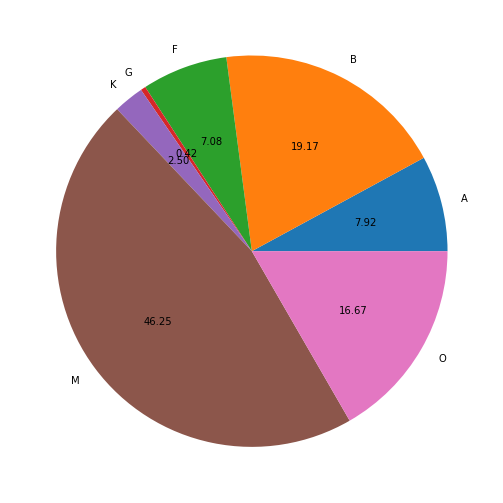

In [11]:
fig, ax = plt.subplots(figsize=(16,9))
df_star.groupby("Spectral_Class").size().plot(kind='pie', autopct='%.2f')

Portanto, a classe espectral não está necessariamente vinculado ao tipo de estrela, já que quase metade dos dados pertence à classe M, enquanto as classes K e G estão pouco representadas.

Podemos analisar também a frequência de conjuntos numéricos, como a temperatura, luminosidade, raio e magnitude absoluta das estrelas. O melhor gráfico para está análise é um histograma.

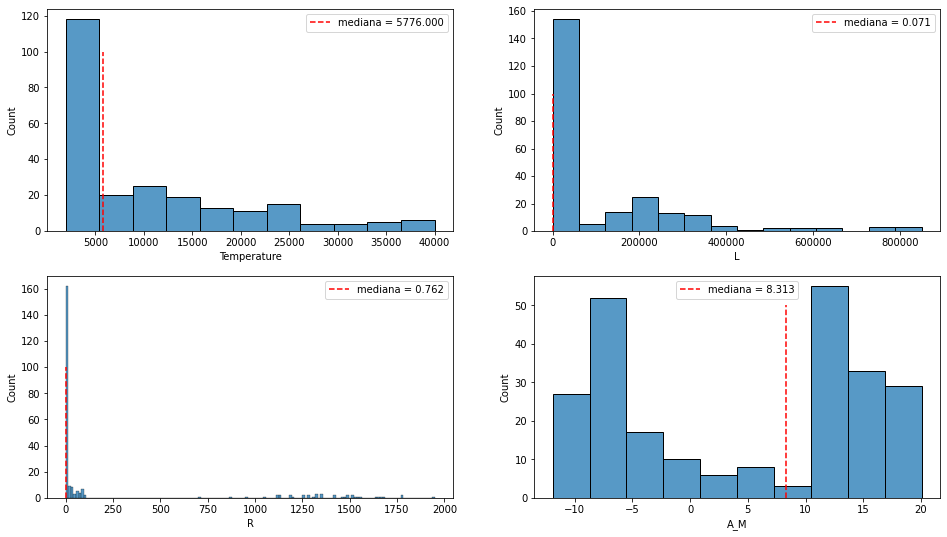

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))

n = len(df_star["Temperature"])

sns.histplot(df_star["Temperature"], bins="fd", ax=ax[0,0])
t = np.median(df_star["Temperature"])# Calcula a mediana dos dados para plotar
ax[0,0].plot([t, t], [0, 100],'r--', label=f"mediana = {t:.3f}")

sns.histplot(df_star["L"], bins="fd", ax=ax[0,1])
l = np.median(df_star["L"])         # Mediana da luminosidade
ax[0,1].plot([l, l], [0, 100],'r--', label=f"mediana = {l:.3f}")

sns.histplot(df_star["R"], bins="fd", ax=ax[1,0])
r = np.median(df_star["R"])         # Mediana do Raio
ax[1,0].plot([r, r], [0, 100],'r--', label=f"mediana = {r:.3f}")

sns.histplot(df_star["A_M"], bins=10, ax=ax[1,1])
a = np.median(df_star["A_M"])         # Mediana da magnitude
ax[1,1].plot([a, a], [0, 50],'r--', label=f"mediana = {a:.3f}")

ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()                  # Exibe as legendas
ax[1,1].legend()

Podemos ver que nenhum dos dados tem comportamento gaussiano. Os três primeiros são unimodais com uma longa cauda, já o histograma da magnitude absoluta mostra que ela aparentemente será bimodal.

Para temperatura, luminosidade e raio, a maior parte dos dados está concentrada em valores baixos, logo alguns dos valores máximos serão considerados *outliers*. Já para a magnitude absoluta, os dados se concentram mais em valores maiores que 10 e menores que -5, com poucos nesse intervalo central.

Outra forma de visualização pode ser usada para verificar a relação de duas classificações. Por exemplo, para observar a variação da magnitude absoluta para diferentes tipos de estrelas, é prático utilizar um gráfico estilo violino.

<AxesSubplot: xlabel='Type', ylabel='A_M'>

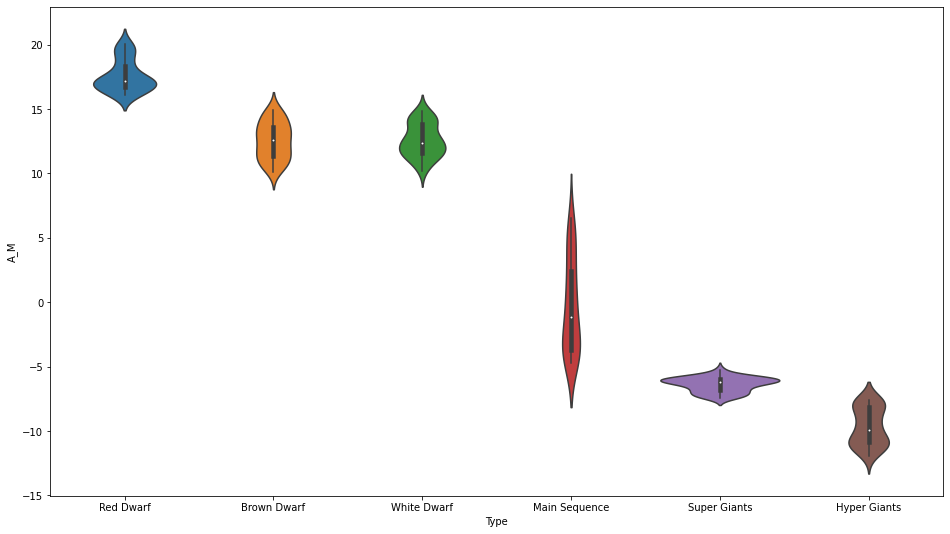

In [13]:
fig, ax = plt.subplots(figsize=(16,9))
sns.violinplot(df_star, x="Type", y="A_M")

Esse gráfico une a informação de frequência de um histograma (grossura do violino), com a distribuição dos dados de um boxplot. Está claro que cada tipo de estrela possui uma região de magnitude bem defininida.

Outra possibilidade é um gráfico de barras, que apresenta o valor médio e uma barra de erro. No gráfico a seguir está a temperatura da estrela em função da cor.

<AxesSubplot: xlabel='Color', ylabel='Temperature'>

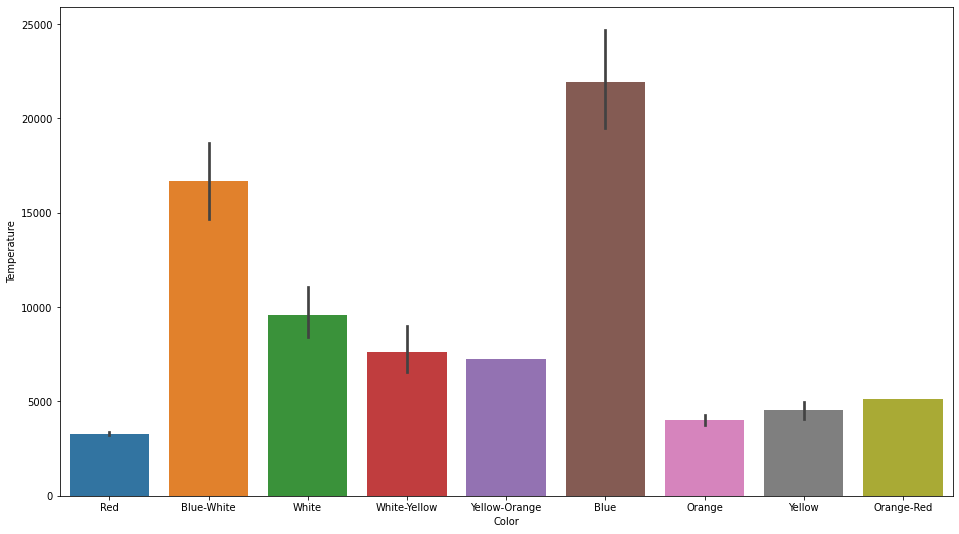

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(df_star, x="Color", y="Temperature")

O gráfico mostra uma crescente da cor vermelha para a cor azul. Como é conhecico que a cor de uma estrela está relacionada com sua temperatura, podemos estabelecer uma ordem para a lista de cores e plotar o gráfico novamente.

(A ideia de ordenar colunas de texto foi baseada na questão deste link: https://stackoverflow.com/questions/13838405/custom-sorting-in-pandas-dataframe)

<AxesSubplot: xlabel='Color', ylabel='Temperature'>

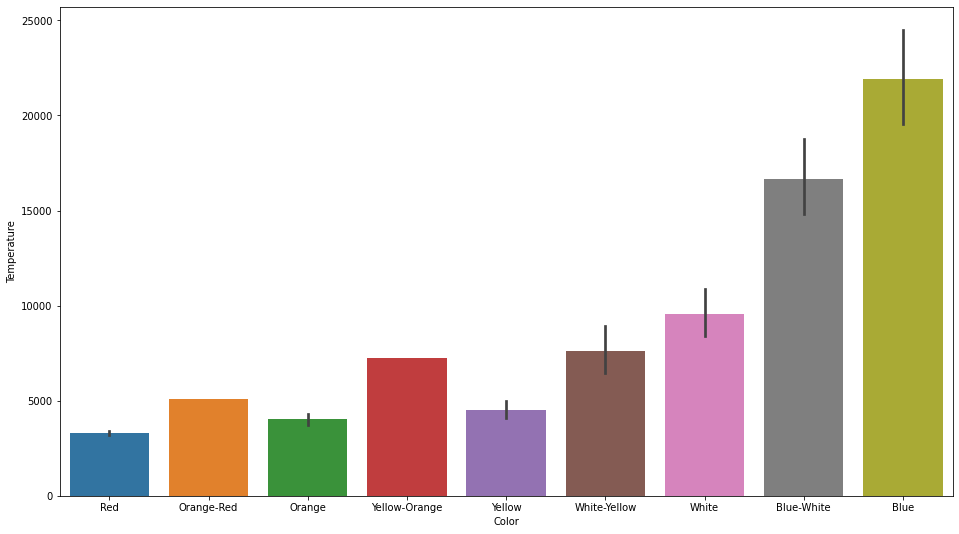

In [15]:
color_order = ["Red", "Orange-Red", "Orange", "Yellow-Orange", "Yellow", "White-Yellow", "White", "Blue-White", "Blue"]
df_star["Color"] = pd.Categorical(df_star["Color"], color_order)    # Estabelece uma ordem para esta categoria

fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(df_star, x="Color", y="Temperature")

Agora está aparente essa relação da temperatura com a cor da estrela.

Outro gráfico interessante é o da temperatura pela classe espectral da estrela, onde também podemos ver outra têndencia crescente.

<AxesSubplot: xlabel='Spectral_Class', ylabel='Temperature'>

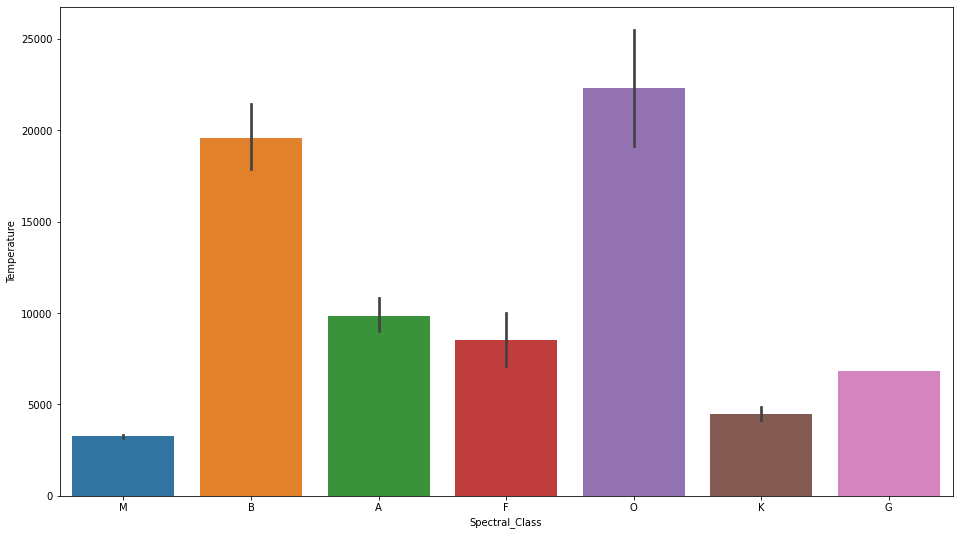

In [16]:
fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(data=df_star, x="Spectral_Class", y="Temperature")

Isso ocorre pois a classe espectral de uma estrela é definida pela sua temperatura\*. Essa classe espectral segue uma ordem crescente: M, K, G, F, A, B, O. Logo, também iremos definir uma ordem para essa categoria e plotar novamente o gráfico.

 #### \*Fonte: https://en.wikipedia.org/wiki/Stellar_classification#Harvard_spectral_classification

<AxesSubplot: xlabel='Spectral_Class', ylabel='Temperature'>

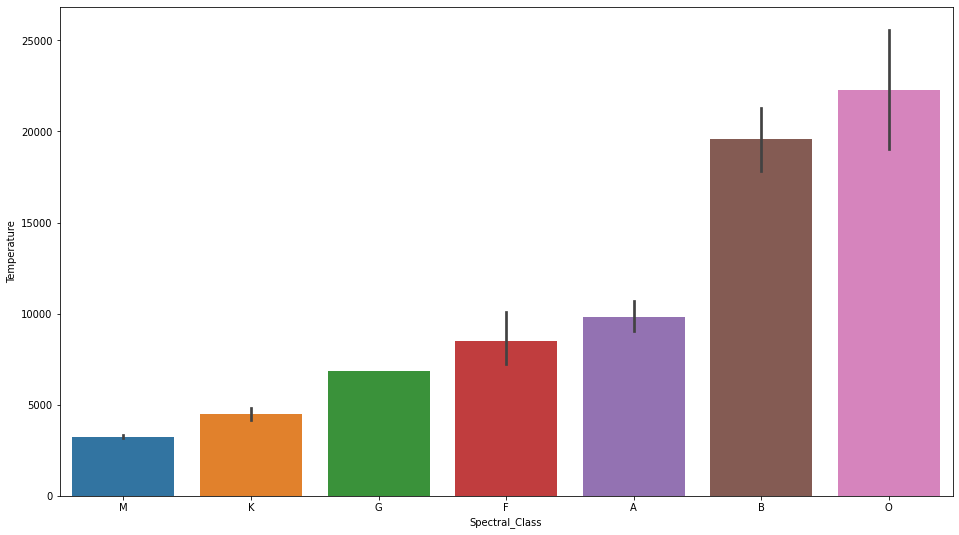

In [17]:
spec_order = ["M", "K", "G", "F", "A", "B", "O"]
df_star["Spectral_Class"] = pd.Categorical(df_star["Spectral_Class"], spec_order)   # Ordena a classe espectral

fig, ax = plt.subplots(figsize=(16,9))
sns.barplot(data=df_star, x="Spectral_Class", y="Temperature")

Agora vemos um comportamento claro, que advem da definição.

Outra forma de ver a relação entre duas categorias é por meio de uma mapa de calor, como se fosse um histograma em duas dimensões. É prático para dois dados categóricos.

<AxesSubplot: xlabel='Color', ylabel='Spectral_Class'>

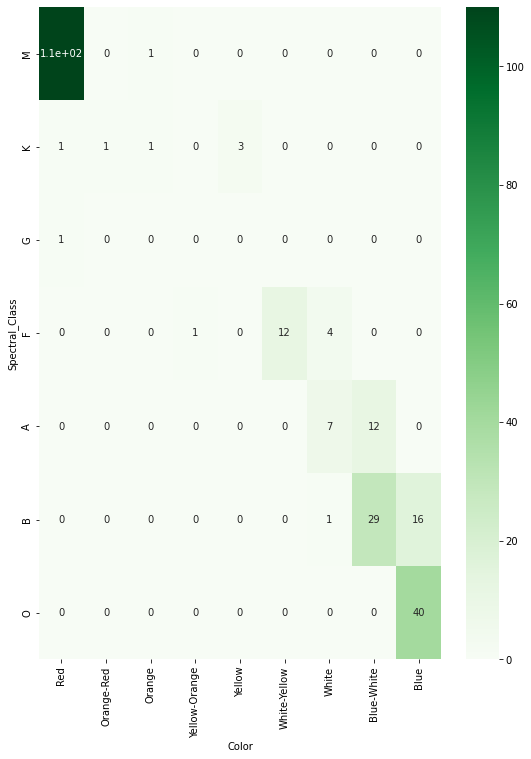

In [18]:
cont = pd.crosstab(df_star["Spectral_Class"], df_star["Color"])   # Monta a tabela cruzada

fig, ax = plt.subplots(figsize=(9,12))
sns.heatmap(cont, annot=True, cmap="Greens")

Por último, podemos reproduzir um famoso gráfico de classificação estelar, que posiciona a magnitude absoluta pela temperatura em um formato de dispersão (*Scatter plot*).

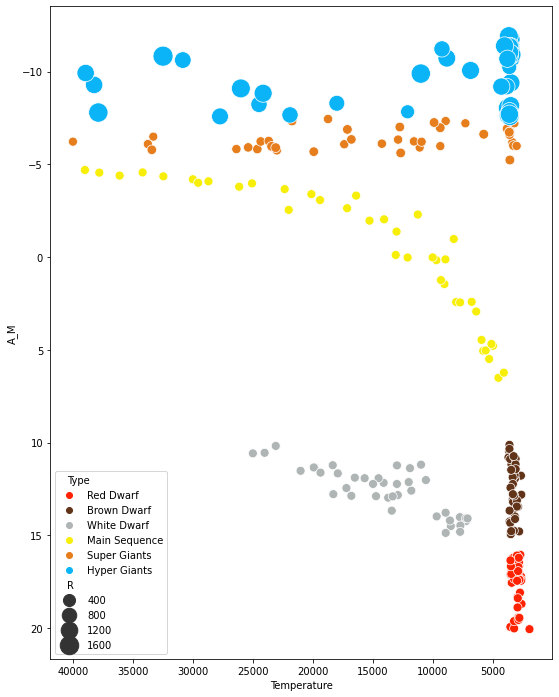

In [19]:
palette_order = ["#ff2200", "#613319", "#aeb5b4", "#f7ef0a", "#e67e1e", "#0ab4f7"] # Ordem das cores a ser utilizada
fig, ax = plt.subplots(figsize=(9,12))


star_plot = sns.scatterplot(data=df_star, x="Temperature", y="A_M", hue="Type", ax=ax, palette=palette_order, size=df_star["R"], sizes=(80, 400))

star_plot.invert_xaxis()    # Esse Gráfico geralmente coloca a magnitude decrescendo (negativo significa mais luminosa) e
star_plot.invert_yaxis()    # Com a tempertaura decrescente também.

Para montar esse gráfico, além da paleta de cores utilizada para combinar com a nomenclatura e cores reais, também foi utilizado um comando para alterar o tamanho da marcação em função do raio real da estrela\*.

Contudo, comparando a figura produzida com de outras fontes (Ex.: https://blogs.egu.eu/divisions/gd/files/2021/07/hrdiagram.png), percebemos que o autor da base de dados deve ter confundido a classe das anãs vermelhas com as anãs marrons, que são remanescente de explosões tipo supernova. As anãs marrons produzem muito pouca luminosidade e possuem baixas temperaturas\** o que permite que queimem por muito mais tempo.

Podemos inverter este erro e produzir um novo gráfico.


#### \* Ideia retirada da própria biblioteca seaborn: https://seaborn.pydata.org/generated/seaborn.scatterplot.html
#### \** Fonte: https://astronomy.swin.edu.au/cosmos/B/brown+dwarf

In [20]:
old_list = ["Red Dwarf", "Brown Dwarf", "White Dwarf", "Main Sequence" , "Super Giants", "Hyper Giants"] # Inf. da fonte
type_list = ["Brown Dwarf", "Red Dwarf", "White Dwarf", "Main Sequence" , "Super Giants", "Hyper Giants"] # Inf. real

df_star["Type"] = df_star["Type"].replace(old_list, type_list)                      # Corrige o nome
df_star["Type"] = pd.Categorical(df_star["Type"], type_list)   # Ordena com base no tipo

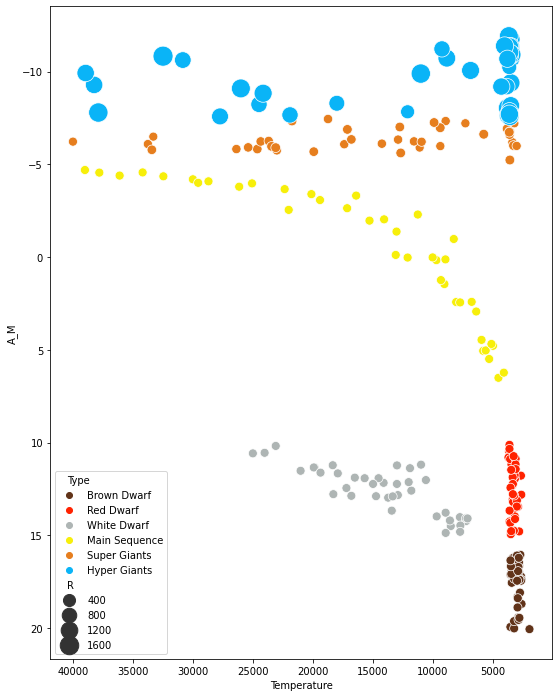

In [21]:
palette_order = ["#613319", "#ff2200", "#aeb5b4", "#f7ef0a", "#e67e1e", "#0ab4f7"] # Corrigindo as cores

fig, ax = plt.subplots(figsize=(9,12))

star_plot = sns.scatterplot(data=df_star, x="Temperature", y="A_M", hue="Type", ax=ax, palette=palette_order, size=df_star["R"], sizes=(80, 400))
star_plot.invert_xaxis()    
star_plot.invert_yaxis()    

# 4 - Estatísticas dos dados

Depois de vermos como algumas das categorias se comportam, podemos utilizar estatísticas analíticas para comparar os dados com uma hipótese.

O Teste de Chi-quadrado serve para verificar se há alguma das categorias utilizadas na frequência dos dados.

In [22]:
cont = pd.crosstab(df_star["Spectral_Class"], df_star["Color"])   # Monta a tabela cruzada
c, p, dof, expected = stats.chi2_contingency(cont)                # Teste chi-quadrado

print(f"Valor de chi-quadrado: {c:.3f}\nGraus de Liberdade: {dof}\nValor de p: {p:.2E}")

Valor de chi-quadrado: 778.203
Graus de Liberdade: 48
Valor de p: 1.59E-132


Como o valor de p deu menor que 5% (Absurdamente menor neste caso), então rejeitamos a hipótese $H_0$ em favor da $H_1$. Isso significa que as categorias possuem influência e há uma relação entre a cor de uma estrela com sua classe espectral.

Outra forma de analisar nossos dados é por meio de um teste de Mann-Whitney, que funciona para dois grupos númericos de dados não paramétricos. Seu objetivo é verificar se os dados surgem de uma mesma distribuição ($H_0$) ou de distribuições diferentes ($H_1$).

In [23]:
class_M = {"Temperature": [],
           "L": [],
           "R": [],                            # Dicionário para a classe M
           "A_M": [],
          }
class_O = {"Temperature": [],
           "L": [],
           "R": [],                            # Dicionário para a classe O
           "A_M": [],
          }
for i in range(240):
    
    if df_star["Spectral_Class"][i] == "M":
        class_M["Temperature"].append(df_star["Temperature"][i])
        class_M["L"].append(df_star["L"][i])                          # Monta as listas específicas para elementos de classe M
        class_M["R"].append(df_star["R"][i])
        class_M["A_M"].append(df_star["A_M"][i])
        
    if df_star["Spectral_Class"][i] == "O":
        class_O["Temperature"].append(df_star["Temperature"][i])
        class_O["L"].append(df_star["L"][i])                          # Monta as listas específicas para elementos de classe O
        class_O["R"].append(df_star["R"][i])
        class_O["A_M"].append(df_star["A_M"][i])


U,pt = stats.mannwhitneyu(class_M["Temperature"], class_O["Temperature"])  # Alternativa para o teste-t de duas amostras independentes
U,pl = stats.mannwhitneyu(class_M["L"], class_O["L"])
U,pr = stats.mannwhitneyu(class_M["R"], class_O["R"])
U,pa = stats.mannwhitneyu(class_M["A_M"], class_O["A_M"])

print(f"{'Valor de p':>24}")
print(f"{'Temperatura':<15}{pt:.3E}\n{'Luminosidade':<15}{pl:.3E}\n{'Raio':<15}{pr:.3E}\n{'Magnitude':<15}{pa:.3E}\n")

              Valor de p
Temperatura    8.036E-21
Luminosidade   1.338E-14
Raio           9.816E-08
Magnitude      4.009E-07



Portanto, para todos os dados númericos da estrela, teremos uma distribuição diferente para as estrelas de classe espectral M e as de classe espectral O.

Também é possível calcular a correlação entre dois conjuntos de dados. Como a nossa base de dados não possui um conjunto com distribuição gaussiana, precisaremos utilizar a correlação de Spearman.

In [24]:
index = ["Temperature", "L", "R", "A_M"]
indice = ["Temperatura", "Luminosidade", "Raio", "Magnitude"]

armario = []
cadeira = []

for i in range(4):
    for j in range(4):
        r,p = stats.spearmanr(df_star[index[i]], df_star[index[j]])  # Correlação para distribuição não normal
        cadeira.append(r)
        armario.append(p)

# print(armario)
# print(correlacao)

print(f"{' '*10}{'Temperatura':^30}{'Luminosidade':^30}{'Raio':^30}{'Magnitude':^30}")

for i in range(16):
    
    if i % 4 == 0:
        print(f"{indice[i//4]:<15}", end='')
        
    print(f"C: {cadeira[i]:<6.3f} p: {armario[i]:<17.2E}", end='')         # Imprimindo as correlações de um jeito bonito
        
    if (i+1) % 4 == 0:
        print("\n\n") 

                   Temperatura                   Luminosidade                      Raio                       Magnitude           
Temperatura    C: 1.000  p: 0.00E+00         C: 0.484  p: 1.81E-15         C: 0.253  p: 7.34E-05         C: -0.520 p: 4.90E-18         


Luminosidade   C: 0.484  p: 1.81E-15         C: 1.000  p: 0.00E+00         C: 0.890  p: 3.57E-83         C: -0.891 p: 1.56E-83         


Raio           C: 0.253  p: 7.34E-05         C: 0.890  p: 3.57E-83         C: 1.000  p: 0.00E+00         C: -0.867 p: 7.50E-74         


Magnitude      C: -0.520 p: 4.90E-18         C: -0.891 p: 1.56E-83         C: -0.867 p: 7.50E-74         C: 1.000  p: 0.00E+00         




Com essa tabela de correlações, podemos ver que, embora Temperatura não possua alta correlação com nenhuma das outras categorias, a Luminosidade possui uma grande correlação com o Raio da estrela e uma grande correlação negativa com a magnitude (o que é de se esperar, dada a definição de magnitude). Também ocorre uma grande correlação negativa do Raio com a magnitude.

Também é possível calcular a correlação de dados categóricos, se eles forem ordinais, utilizando a correlação de Kendall. 

In [25]:
corr, p = stats.kendalltau(df_star["Spectral_Class"], df_star["Type"]) # Correlação dados categóricos
print(f"{'Correlação entre Classe Espectral e Tipo':<45}C: {corr:.3f}  p: {p:.3E}")
corr, p = stats.kendalltau(df_star["Color"], df_star["Type"])
print(f"{'Correlação entre Cor e Tipo':<45}C: {corr:.3f}  p: {p:.3E}")
corr, p = stats.kendalltau(df_star["Spectral_Class"], df_star["Color"])
print(f"{'Correlação entre Classe Espectral e Cor':<45}C: {corr:.3f}  p: {p:.3E}")

Correlação entre Classe Espectral e Tipo     C: -0.115  p: 2.720E-02
Correlação entre Cor e Tipo                  C: -0.244  p: 3.280E-06
Correlação entre Classe Espectral e Cor      C: -0.147  p: 6.734E-03


Logo a correlação é negativa, mas não é muito forte entre estas categorias.


# 5 - Prevendo a classificação de novos dados

Agora, utilizaremos um algoritmo de Machine Learning Supervisionado para, com base nos dados atuais, prever em qual classificação de Tipo de estrela ele se encaixaria. O conjunto de dados que possui esses tipos de estrelas bem definidos é o da Magnitude absoluta pela Temperatura, do mesmo jeito que foi produzido o *Scatterplot* anteriormente.

In [26]:
data = df_star[["Temperature", "A_M"]]   # Seleciona as colunas temperatura e Magnitude para a lista nova
data = np.array(data)                    # Transforma em uma array do numpy

Agora que temos a lista de dados pronta, iremos organizar o *Data Frame*, ordenando-o com relação ao tipo de estrelas. Dessa forma, ao utilizar o algoritmo de Machine Learning, ele irá identificar os grupos de estrelas e conseguirá informar o grupo da nova estrela.

In [27]:
df_star.sort_values(by=['Type'], inplace=True)  #Ordena o DataFrame

print(f"\n\nClassificação Nova:\n{df_star['Type'].value_counts()}")



Classificação Nova:
Brown Dwarf      40
Red Dwarf        40
White Dwarf      40
Main Sequence    40
Super Giants     40
Hyper Giants     40
Name: Type, dtype: int64


Iremos criar uma nova estrela com coordenadas aleatórias nesse plano de Magnitude e Temperatura. Para isso utilizamos o comando *random* para multiplicar a coordenada X por um valor aleatório entre \[0,1), e multiplicamos a coordenada Y por *randn*, que será um número retirado da distribuição gaussiana centralizada em zero.

In [28]:
newpoint = [40000*np.random.random(), 10*np.random.randn()]
newpoint = np.array(newpoint)
print(f"Coordenadas do novo ponto: [{newpoint[0]:.3E}, {newpoint[1]:.3E}]")

Coordenadas do novo ponto: [2.427E+04, 2.454E+00]


Com esses valores prontos, podemos rodar o algoritmo e apresentar o grupo que ele encaixou a nova estrela.

In [29]:
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')   # Função dos N-vizinhos
knn.fit(data, df_star["Type"])

whichgroupP = knn.predict(newpoint.reshape(1,-1))               # Determina em qual grupo o dado se encaixa

print(f'A nova estrela é do tipo: "{str(whichgroupP[0])}"')

A nova estrela é do tipo: "Hyper Giants"


Para visualizar isso, produzimos o gráfico anterior com o novo ponto.

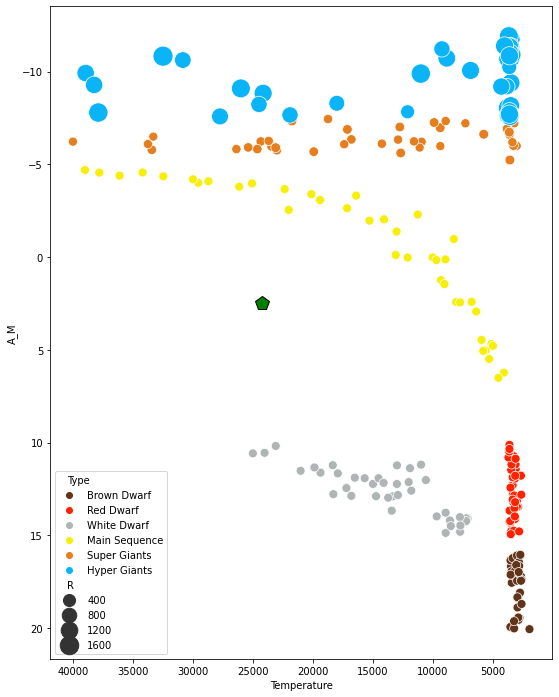

In [30]:
palette_order = ["#613319", "#ff2200", "#aeb5b4", "#f7ef0a", "#e67e1e", "#0ab4f7"] 

fig, ax = plt.subplots(figsize=(9,12))

star_plot = sns.scatterplot(data=df_star, x="Temperature", y="A_M", hue="Type", ax=ax, palette=palette_order, size=df_star["R"], sizes=(80, 400))
star_plot.invert_xaxis()    
star_plot.invert_yaxis()

plt.plot(newpoint[0], newpoint[1],'kp',markerfacecolor='g',markersize=15)  # Nova estrela

Ao repetir a execução dessa seção do código , é possível perceber que na maioria das vezes ele aponta um grupo improvável para a nova estrela. Isso ocorre pois os eixos do gráfico estão em dimensões diferentes, portanto, ao analisar os vizinhos mais próximos, estrelas que possuem temperaturas semelhantes, mas magnitude diferentes serão consideradas mais próximas do que as estrelas "vizinhas" horizontalmente no gráfico (Magnitudes semelhantes e Temperauras diferentes).

Portanto, é necessário criar outra função para calcular a distância entre estrelas, de forma que ela dê pesos diferentes para cada dimensão. Porém, isso ficará como sugestão para um próximo dia e não será realizado neste pojeto.

# 6 - Conclusão

Embora o *Data Frame* utilizado não tenha sido extenso, ou muito complexo, ele se provou muito útil para testar as diversas análises e procedimentos aprendidos durante o curso. Conseguimos, com relativa facilidade, aplicar as várias funções descritivas e também visualizar o comportamento dos dados. Além disso, fomos capazes de reproduzir com grande qualidade o gráfico de classificação estelar, um dos principais da área de astronomia e o principal objetivo pretendido ao utilizarmos esta base de dados.